In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!git clone --recursive https://github.com/frank-xwang/UnSAM.git

In [ ]:
!python -m pip install 'git+https://github.com/MaureenZOU/detectron2-xyz.git'
%cd UnSAM
!python -m pip install -r requirements.txt

# uncomment the following lines if you want to run with GPU
%cd whole_image_segmentation/mask2former/modeling/pixel_decoder/ops
!sh make.sh

In [1]:
# clone and install Mask2Former
!git clone https://github.com/facebookresearch/Mask2Former.git
%cd Mask2Former
!pip install -U opencv-python
!pip install git+https://github.com/cocodataset/panopticapi.git
!pip install -r requirements.txt
%cd mask2former/modeling/pixel_decoder/ops
!python setup.py build install
%cd ../../../../

Cloning into 'Mask2Former'...
remote: Enumerating objects: 297, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 297 (delta 118), reused 112 (delta 112), pack-reused 87 (from 1)
Receiving objects: 100% (297/297), 408.20 KiB | 10.20 MiB/s, done.
Resolving deltas: 100% (134/134), done.
/kaggle/working/Mask2Former
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-c9swna6d
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-c9swna6d
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py) ... done
/kaggle/working/Mask2Former/mask2former/modeling/pixel_decoder/ops
/opt/conda/lib/python3.10/site-packages/torch/utils/cpp_extension.py:424: UserWarning: There are no g++ version bounds defined for CUDA version 12.1
  warnings.warn(f'There are no {com

In [2]:
# You may need to restart your runtime prior to this, to let your installation take effect
#%cd /kaggle/working/UnSAM/whole_image_segmentation/mask2former/modeling/pixel_decoder/ops/Mask2Former/Mask2Former
# Some basic setup:
# Setup detectron2 logger
#%cd /kaggle/working/UnSAM/Mask2Former
#%cd /kaggle/working/UnSAM/Mask2Former/Mask2Former/UnSAM/Mask2Former
#%cd /kaggle/working/UnSAM/Mask2Former/Mask2Former
%cd /kaggle/working/Mask2Former
#%cd /kaggle/working/UnSAM/whole_image_segmentation/mask2former/modeling/pixel_decoder/ops/Mask2Former

#%cd /kaggle/working/UnSAM/whole_image_segmentation/mask2former
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="mask2former")

# import some common libraries
import numpy as np
import cv2
import torch
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.projects.deeplab import add_deeplab_config
coco_metadata = MetadataCatalog.get("coco_2017_val_panoptic")

# import Mask2Former project
from mask2former import add_maskformer2_config

/kaggle/working/Mask2Former


In [3]:
import argparse
from detectron2.engine import DefaultPredictor, default_setup
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.config import get_cfg
from detectron2.utils.colormap import random_color
from mask2former import add_maskformer2_config
import cv2
import os
from tqdm import tqdm
import PIL.Image as Image

In [4]:
def setup(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    cfg.set_new_allowed(True)
    # for poly lr schedule
    add_deeplab_config(cfg)
    add_maskformer2_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    default_setup(cfg, args)
    return cfg

In [5]:
def get_parser(inputs):
    parser = argparse.ArgumentParser(description="Detectron2 demo for builtin configs")
    parser.add_argument(
        "--config-file",
        default="configs/quick_schedules/mask_rcnn_R_50_FPN_inference_acc_test.yaml",
        metavar="FILE",
        help="path to config file",
    )
    parser.add_argument(
        "--opts",
        help="Modify config options using the command-line 'KEY VALUE' pairs",
        default=[],
        nargs=argparse.REMAINDER,
    )
    args = parser.parse_args(inputs)
    return args

In [6]:
import numpy as np
def area(mask):
    if mask.size == 0: return 0
    return np.count_nonzero(mask) / mask.size

def vis_mask(input, mask, mask_color) :
    fg = mask > 0.5
    rgb = np.copy(input)
    rgb[fg] = (rgb[fg] * 0.5 + np.array(mask_color) * 0.5).astype(np.uint8)
    return Image.fromarray(rgb)

def show_image(I, pool):
    # the visualization strategy is small masks on top of large masks
    already_painted = np.zeros(np.array(I).shape[:2])
    input = I.copy()
    i = 0
    for mask in tqdm(pool):
        already_painted += mask.astype(np.uint8)
        overlap = (already_painted == 2)
        if np.sum(overlap) != 0:
            input = Image.fromarray(overlap[:, :, np.newaxis] * np.copy(I) + np.logical_not(overlap)[:, :, np.newaxis] * np.copy(input))
            already_painted -= overlap
        input = vis_mask(input, mask, random_color(rgb=True))
    display(input)

# **UNSAM+**

In [7]:
!pip install gdown

In [8]:
!gdown https://drive.google.com/uc?id=1sCZM5j2pQr34-scSEkgG7VmUaHJc8n4d # unsam_plus_sa1b_1perc_ckpt_50k.pth
# !gdown https://drive.google.com/uc?id=1qUdZ2ELU_5SNTsmx3Q0wSA87u4SebiO4  # unsam_sa1b_4perc_ckpt_200k.pth

Downloading...
From (original): https://drive.google.com/uc?id=1sCZM5j2pQr34-scSEkgG7VmUaHJc8n4d
From (redirected): https://drive.google.com/uc?id=1sCZM5j2pQr34-scSEkgG7VmUaHJc8n4d&confirm=t&uuid=fe0388c9-8187-4b9a-8a47-ebf398b52f1c
To: /kaggle/working/Mask2Former/unsam_plus_sa1b_1perc_ckpt_50k.pth
100%|█████████████████████████████████████████| 540M/540M [00:05<00:00, 102MB/s]


In [9]:
# Using ***CPU*** by default. to run on GPU, remove "MODEL.DEVICE", "cpu".
# By default we only select first 1000 highest confidence score masks. The maximum query is 2000, add "TEST.DETECTIONS_PER_IMAGE", "2000" to get all masks
inputs = ['--config-file', "/kaggle/working/UnSAM/whole_image_segmentation/configs/maskformer2_R50_bs16_50ep.yaml", "--opts", "MODEL.WEIGHTS", "/kaggle/working/Mask2Former/unsam_plus_sa1b_1perc_ckpt_50k.pth", "MODEL.DEVICE", "cpu"]
args = get_parser(inputs)

In [10]:
pred = DefaultPredictor(setup(args))

[08/16 11:35:42 detectron2]: Rank of current process: 0. World size: 1
[08/16 11:35:42 detectron2]: Rank of current process: 0. World size: 1
[08/16 11:35:43 detectron2]: Environment info:
----------------------  ------------------------------------------------------------------------------
sys.platform            linux
Python                  3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
numpy                   1.26.4
detectron2              0.6 @/opt/conda/lib/python3.10/site-packages/detectron2
Compiler                GCC 9.4
CUDA compiler           CUDA 12.1
detectron2 arch flags   6.0
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 2.1.2 @/opt/conda/lib/python3.10/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   Tesla P100-PCIE-16GB (arch=6.0)
Driver version          550.90.07
CUDA_HOME               /usr/local/cuda
Pillow                  9.5.0
torchvision             0.16.2 @/opt/cond

In [11]:
import os

# Change working directory if necessary
# os.chdir('..')  # Uncomment and modify if needed

# Verify file path and existence
config_file_path = '/kaggle/working/UnSAM/whole_image_segmentation/configs/maskformer2_R50_bs16_50ep.yaml'
if not os.path.isfile(config_file_path):
    print(f"Error: Config file '{config_file_path}' not found.")
    # Download or create the file here
else:
    # Continue with the rest of your code
    pred = DefaultPredictor(setup(args))

[08/16 11:36:05 detectron2]: Rank of current process: 0. World size: 1
[08/16 11:36:05 detectron2]: Rank of current process: 0. World size: 1
[08/16 11:36:05 detectron2]: Environment info:
----------------------  ------------------------------------------------------------------------------
sys.platform            linux
Python                  3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
numpy                   1.26.4
detectron2              0.6 @/opt/conda/lib/python3.10/site-packages/detectron2
Compiler                GCC 9.4
CUDA compiler           CUDA 12.1
detectron2 arch flags   6.0
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 2.1.2 @/opt/conda/lib/python3.10/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   Tesla P100-PCIE-16GB (arch=6.0)
Driver version          550.90.07
CUDA_HOME               /usr/local/cuda
Pillow                  9.5.0
torchvision             0.16.2 @/opt/cond

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


You have 49 masks for this image


100%|██████████| 49/49 [00:00<00:00, 831.37it/s]


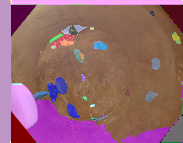

In [12]:
# specify the path here if you want to try your own images
inputs = cv2.imread("/kaggle/input/try-datset/Try_2_ESD.png")
pred.input_format = "BGR"
outputs = pred(inputs)['instances']
masks = []
for score, mask in zip(outputs.scores, outputs.pred_masks):
    # set the confidence threshold for selecting masks here, you can increase it to speed up the visualization process
    # or you can resize the image to speed up. The example images from SA-1B have relatively high resolution
    if score < 0.5: continue
    masks.append(mask.cpu().numpy())
sorted_masks = sorted(masks, key=lambda m: area(m), reverse=True)
print(f"You have {len(sorted_masks)} masks for this image")
show_image(inputs, sorted_masks)

# **UNSAM**

In [ ]:
!pip install gdown

In [13]:
#!gdown https://drive.google.com/uc?id=1sCZM5j2pQr34-scSEkgG7VmUaHJc8n4d # unsam_plus_sa1b_1perc_ckpt_50k.pth
!gdown https://drive.google.com/uc?id=1qUdZ2ELU_5SNTsmx3Q0wSA87u4SebiO4  # unsam_sa1b_4perc_ckpt_200k.pth

Downloading...
From (original): https://drive.google.com/uc?id=1qUdZ2ELU_5SNTsmx3Q0wSA87u4SebiO4
From (redirected): https://drive.google.com/uc?id=1qUdZ2ELU_5SNTsmx3Q0wSA87u4SebiO4&confirm=t&uuid=1322a5c3-cfd7-45c4-9783-7f5f708fc241
To: /kaggle/working/Mask2Former/unsam_sa1b_4perc_ckpt_200k.pth
100%|████████████████████████████████████████| 540M/540M [00:05<00:00, 97.8MB/s]


In [14]:
# Using ***CPU*** by default. to run on GPU, remove "MODEL.DEVICE", "cpu".
# By default we only select first 1000 highest confidence score masks. The maximum query is 2000, add "TEST.DETECTIONS_PER_IMAGE", "2000" to get all masks
inputs = ['--config-file', "/kaggle/working/UnSAM/whole_image_segmentation/configs/maskformer2_R50_bs16_50ep.yaml", "--opts", "MODEL.WEIGHTS", "/kaggle/working/Mask2Former/unsam_sa1b_4perc_ckpt_200k.pth", "MODEL.DEVICE", "cpu"]
args = get_parser(inputs)

In [15]:
pred = DefaultPredictor(setup(args))

[08/16 11:38:29 detectron2]: Rank of current process: 0. World size: 1
[08/16 11:38:29 detectron2]: Rank of current process: 0. World size: 1
[08/16 11:38:29 detectron2]: Environment info:
----------------------  ------------------------------------------------------------------------------
sys.platform            linux
Python                  3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
numpy                   1.26.4
detectron2              0.6 @/opt/conda/lib/python3.10/site-packages/detectron2
Compiler                GCC 9.4
CUDA compiler           CUDA 12.1
detectron2 arch flags   6.0
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 2.1.2 @/opt/conda/lib/python3.10/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   Tesla P100-PCIE-16GB (arch=6.0)
Driver version          550.90.07
CUDA_HOME               /usr/local/cuda
Pillow                  9.5.0
torchvision             0.16.2 @/opt/cond

In [16]:
import os

# Change working directory if necessary
# os.chdir('..')  # Uncomment and modify if needed

# Verify file path and existence
config_file_path = '/kaggle/working/UnSAM/whole_image_segmentation/configs/maskformer2_R50_bs16_50ep.yaml'
if not os.path.isfile(config_file_path):
    print(f"Error: Config file '{config_file_path}' not found.")
    # Download or create the file here
else:
    # Continue with the rest of your code
    pred = DefaultPredictor(setup(args))

[08/16 11:38:53 detectron2]: Rank of current process: 0. World size: 1
[08/16 11:38:53 detectron2]: Rank of current process: 0. World size: 1
[08/16 11:38:54 detectron2]: Environment info:
----------------------  ------------------------------------------------------------------------------
sys.platform            linux
Python                  3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
numpy                   1.26.4
detectron2              0.6 @/opt/conda/lib/python3.10/site-packages/detectron2
Compiler                GCC 9.4
CUDA compiler           CUDA 12.1
detectron2 arch flags   6.0
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 2.1.2 @/opt/conda/lib/python3.10/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   Tesla P100-PCIE-16GB (arch=6.0)
Driver version          550.90.07
CUDA_HOME               /usr/local/cuda
Pillow                  9.5.0
torchvision             0.16.2 @/opt/cond

You have 124 masks for this image


100%|██████████| 124/124 [00:00<00:00, 826.52it/s]


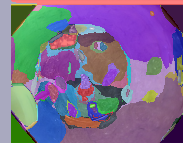

In [17]:
# specify the path here if you want to try your own images
inputs = cv2.imread("/kaggle/input/try-datset/Try_2_ESD.png")
pred.input_format = "BGR"
outputs = pred(inputs)['instances']
masks = []
for score, mask in zip(outputs.scores, outputs.pred_masks):
    # set the confidence threshold for selecting masks here, you can increase it to speed up the visualization process
    # or you can resize the image to speed up. The example images from SA-1B have relatively high resolution
    if score < 0.5: continue
    masks.append(mask.cpu().numpy())
sorted_masks = sorted(masks, key=lambda m: area(m), reverse=True)
print(f"You have {len(sorted_masks)} masks for this image")
show_image(inputs, sorted_masks)

# **GUI**

In [20]:
import tkinter as tk
from tkinter import filedialog
from tkinter import Label
from PIL import Image, ImageTk
import cv2
import numpy as np
from detectron2.engine import DefaultPredictor

# Load your models here
def load_models():
    unsam_plus_inputs = ['--config-file', "/kaggle/working/UnSAM/whole_image_segmentation/configs/maskformer2_R50_bs16_50ep.yaml", "--opts", "MODEL.WEIGHTS", "/kaggle/working/Mask2Former/unsam_plus_sa1b_1perc_ckpt_50k.pth", "MODEL.DEVICE", "cpu"]
    unsam_inputs = ['--config-file', "/kaggle/working/UnSAM/whole_image_segmentation/configs/maskformer2_R50_bs16_50ep.yaml", "--opts", "MODEL.WEIGHTS", "/kaggle/working/Mask2Former/unsam_sa1b_4perc_ckpt_200k.pth", "MODEL.DEVICE", "cpu"]
    
    unsam_plus_predictor = DefaultPredictor(setup(get_parser(unsam_plus_inputs)))
    unsam_predictor = DefaultPredictor(setup(get_parser(unsam_inputs)))
    
    return unsam_plus_predictor, unsam_predictor

# Display images
def show_image(original_img, unsam_plus_output, unsam_output):
    # Resize images if necessary
    original_img = cv2.resize(original_img, (300, 300))
    unsam_plus_output = cv2.resize(unsam_plus_output, (300, 300))
    unsam_output = cv2.resize(unsam_output, (300, 300))
    
    # Convert to PIL images
    original_img_pil = Image.fromarray(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    unsam_plus_output_pil = Image.fromarray(cv2.cvtColor(unsam_plus_output, cv2.COLOR_BGR2RGB))
    unsam_output_pil = Image.fromarray(cv2.cvtColor(unsam_output, cv2.COLOR_BGR2RGB))

    # Convert to ImageTk format
    original_img_tk = ImageTk.PhotoImage(original_img_pil)
    unsam_plus_output_tk = ImageTk.PhotoImage(unsam_plus_output_pil)
    unsam_output_tk = ImageTk.PhotoImage(unsam_output_pil)
    
    # Display the images in the labels
    original_label.config(image=original_img_tk)
    unsam_plus_label.config(image=unsam_plus_output_tk)
    unsam_label.config(image=unsam_output_tk)
    
    # Keep a reference to avoid garbage collection
    original_label.image = original_img_tk
    unsam_plus_label.image = unsam_plus_output_tk
    unsam_label.image = unsam_output_tk

# Process the image using UNSAM+ and UNSAM
def process_image(filepath):
    original_img = cv2.imread(filepath)
    
    # Get predictions from both models
    unsam_plus_output = predict(unsam_plus_predictor, original_img)
    unsam_output = predict(unsam_predictor, original_img)
    
    # Display the images
    show_image(original_img, unsam_plus_output, unsam_output)

# Predict and get masks
def predict(predictor, img):
    outputs = predictor(img)['instances']
    masks = [mask.cpu().numpy() for score, mask in zip(outputs.scores, outputs.pred_masks) if score >= 0.5]
    sorted_masks = sorted(masks, key=lambda m: area(m), reverse=True)
    combined_mask = np.zeros_like(sorted_masks[0])
    
    for mask in sorted_masks:
        combined_mask = np.maximum(combined_mask, mask)
    
    return (img * combined_mask[:, :, np.newaxis]).astype(np.uint8)


In [21]:

# GUI setup
def open_file():
    filepath = filedialog.askopenfilename()
    if filepath:
        process_image(filepath)

unsam_plus_predictor, unsam_predictor = load_models()


[08/16 11:43:54 detectron2]: Rank of current process: 0. World size: 1
[08/16 11:43:54 detectron2]: Rank of current process: 0. World size: 1
[08/16 11:43:54 detectron2]: Environment info:
----------------------  ------------------------------------------------------------------------------
sys.platform            linux
Python                  3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
numpy                   1.26.4
detectron2              0.6 @/opt/conda/lib/python3.10/site-packages/detectron2
Compiler                GCC 9.4
CUDA compiler           CUDA 12.1
detectron2 arch flags   6.0
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 2.1.2 @/opt/conda/lib/python3.10/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   Tesla P100-PCIE-16GB (arch=6.0)
Driver version          550.90.07
CUDA_HOME               /usr/local/cuda
Pillow                  9.5.0
torchvision             0.16.2 @/opt/cond

In [23]:
from tkinter import *
import random
from time import sleep
from tkinter import messagebox
import threading

root = Tk()
# Create the root window
#root = tk.Tk()
root.title("UNSAM Image Processing")

# Buttons and Labels
open_button = tk.Button(root, text="Open Image", command=open_file)
open_button.pack()

original_label = Label(root)
unsam_plus_label = Label(root)
unsam_label = Label(root)

original_label.pack(side="left")
unsam_plus_label.pack(side="left")
unsam_label.pack(side="left")

# Start the GUI event loop
root.mainloop()


TclError: no display name and no $DISPLAY environment variable

# **Streamlit**

In [24]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 71.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 5.0 MB/s eta 0:00:00


In [25]:
import streamlit as st
from PIL import Image
import cv2
import numpy as np

# Function to load an image
def load_image(image_file):
    img = Image.open(image_file)
    return img

# Function to process the image using UNSAM+ and UNSAM models
def process_image(image):
    image_cv = np.array(image.convert('RGB'))  # Convert PIL image to OpenCV format
    image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)
    
    # Process with UNSAM+
    unsam_plus_masks = pred_unsam_plus(image_cv)
    unsam_plus_output = visualize_masks(image_cv, unsam_plus_masks)

    # Process with UNSAM
    unsam_masks = pred_unsam(image_cv)
    unsam_output = visualize_masks(image_cv, unsam_masks)

    return unsam_plus_output, unsam_output

# Function to visualize masks on the image
def visualize_masks(image, masks):
    output_image = np.copy(image)
    for mask in masks:
        color = np.random.randint(0, 255, size=(3,), dtype=int).tolist()
        output_image[mask > 0.5] = (np.array(color) * 0.5 + output_image[mask > 0.5] * 0.5).astype(np.uint8)
    return output_image

# Function to predict using UNSAM+
def pred_unsam_plus(image):
    outputs = pred_unsam_plus(image)['instances']
    masks = [mask.cpu().numpy() for score, mask in zip(outputs.scores, outputs.pred_masks) if score >= 0.5]
    return sorted(masks, key=lambda m: np.sum(m), reverse=True)

# Function to predict using UNSAM
def pred_unsam(image):
    outputs = pred_unsam(image)['instances']
    masks = [mask.cpu().numpy() for score, mask in zip(outputs.scores, outputs.pred_masks) if score >= 0.5]
    return sorted(masks, key=lambda m: np.sum(m), reverse=True)

# Streamlit app
st.title("UNSAM Image Processing")

# File uploader
image_file = st.file_uploader("Upload an Image", type=["png", "jpg", "jpeg"])

if image_file is not None:
    st.image(load_image(image_file), caption="Original Image", use_column_width=True)
    
    # Process the image
    unsam_plus_output, unsam_output = process_image(load_image(image_file))

    # Display the results
    st.image(unsam_plus_output, caption="UNSAM+ Output", use_column_width=True)
    st.image(unsam_output, caption="UNSAM Output", use_column_width=True)


2024-08-16 11:49:04.419 
  command:

    streamlit run /opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


In [28]:
!streamlit run /opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.19.2.2:8501
  External URL: http://34.82.117.182:8501

^C
  Stopping...
